# Methodology
**Note: This notebook is under active development and will change *a lot*.**

## The Problem
**H**igh-**P**erformance **L**iquid **C**hromatography (HPLC) is an analytical 
technique which allows for the quantitative characterization of the chemical
components of a mixture. While many of the technical details of HPLC are now
automated, the programmatic cleaning and processing of the resulting data can be
cumbersome and often requires extensive manual labor. 


Consider a scenario where you have an environmental sample that contains several 
different chemical species. Through the principle of [chromatographic separation](https://en.wikipedia.org/wiki/Chromatography), you use an HPLC instrument to decompose the sample into its
constituents by measuring the time it takes for each analyte to pass through 
the column. The resulting data is a chromatogram, which may look something like 
this

Text(0, 0.5, 'signal [mV]')

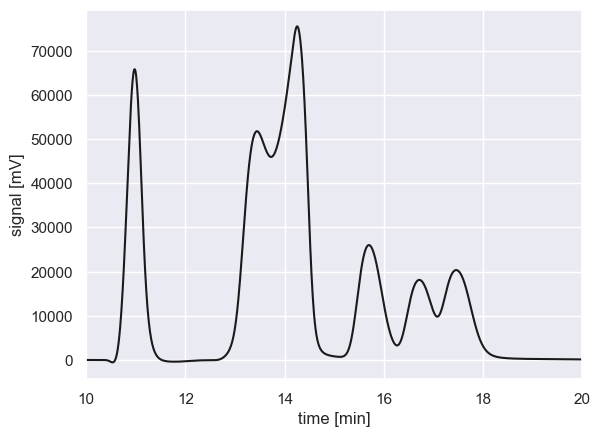

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load the measurement 
data = pd.read_csv('./data/sample_chromatogram.txt')

# Plot the chromatogram
fig, ax = plt.subplots(1,1)
ax.plot(data['time_min'], data['intensity_mV'], 'k-')
ax.set_xlim(10, 20)
ax.set_xlabel('time [min]')
ax.set_ylabel('signal [mV]')

By eye, it looks like there may be six individual compounds in the sample. Some 
are isolated (e.g., the peak at 11 min) while others are severely overlapping
(e.g. the peaks from 13-15 min). This indicates that some of the compounds 
have similar elution times through the column with this particular mobile phase.

While its easy for us to see these peaks, how do we quantify them? How can 
we tease apart peaks that are overlapping? This is easier to say than to do. 
There are several tools available to do this that are open source (such as [HappyTools](https://github.com/Tarskin/HappyTools)) 
or proprietary (such as [Chromeleon](https://www.thermofisher.com/order/catalog/product/CHROMELEON7)). However,
in many cases peaks are quantified simply but integrating only the non-overlapping 
regions. 

Hplc-Py, however, fits mixtures of skewnormal distributions to regions of the 
chromatogram that contain either singular or highly overlapping peaks, allowing 
one to go from the chromatogram above to a decomposed mixture in a few lines 
of Python code.


Deconvolving mixture: 100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


,retention_time,scale,skew,amplitude,area,peak_id
0,10.90,0.157450,0.674286,23250.349387,2.790042e+06,1
0,13.17,0.582866,3.839860,42250.783974,5.070094e+06,2
0,14.45,0.353036,-3.019153,35229.583555,4.227550e+06,3
0,15.53,0.312563,1.630787,14891.041452,1.786925e+06,4
0,16.52,0.344266,1.984167,10770.656732,1.292479e+06,5


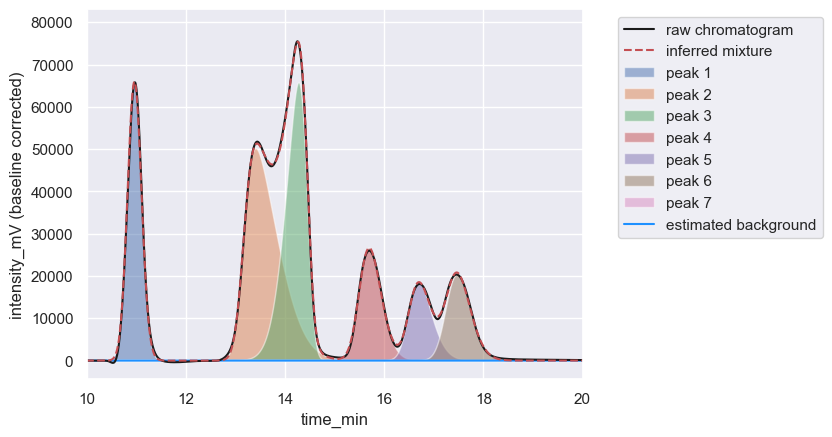

In [2]:
# Show the power of hplc-py
import hplc.quant
chrom = hplc.quant.Chromatogram(data, cols={'time':'time_min', 'signal':'intensity_mV'})
peaks = chrom.fit_peaks()

# Display the results
chrom.show(time_range=[10, 20])
peaks.head()


### How It Works
The peak detection and quantification algorithm in `hplc-py` involves the following 
steps.

1. Estimation of signal background using [Statistical Nonlinear Iterative Peak (SNIP) estimation](https://doi.org/10.1366/000370208783412762). 
2. Automatic detection of peak maxima given threshold criteria (such as peak prominence).
3. Clipping of the chromatogram into "peak windows" which contain at least one 
peak. Regions of the chromatogram which are stacked with heavily overlapping signals
are grouped into single windows. 
4. For a window with $N$ peaks, a mixture of $N$ skew-normal disttributions are inferred using the measured peak properties (such as location, maximum value, and width at half-maximum) are used as initial guesses. This inference is performed through an optimization by minimization procedure. This inference is repeated for each window in the 
chromatogram. 
5. Given best-fit parameters for each distribution, the expected signal of the 
compound across the entire observation window is computed. The integrated signal 
over the entire peak is computed and stored.
6. The estimated mixture of all compounds is computed given the parameter estimates 
of each distribution. 

The rest of this notebook will examine in detail how each of these steps is 
implemented.

#### Step 1: Correcting for a Drifting Baseline

#### Step 2: Identification of Peak Maxima and Including Obscured Peaks

#### Step 3: Clipping the Chromatogram Into Windows

#### Step 4: Per-Window Estimation of Constituent Signals

#### Steps 5 & 6: Integration of Signal and Evaluating Composition of Mixture